In [1]:
import mne

In [2]:
std_1020 = mne.channels.make_standard_montage(
    'standard_1020')

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


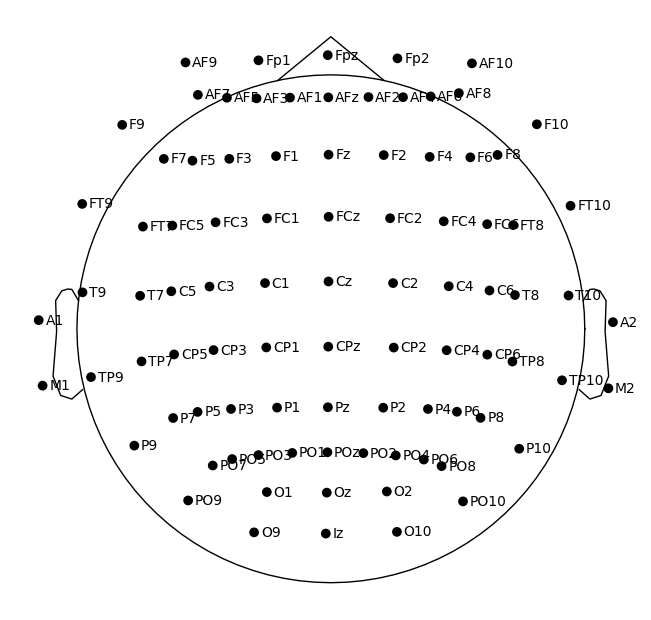

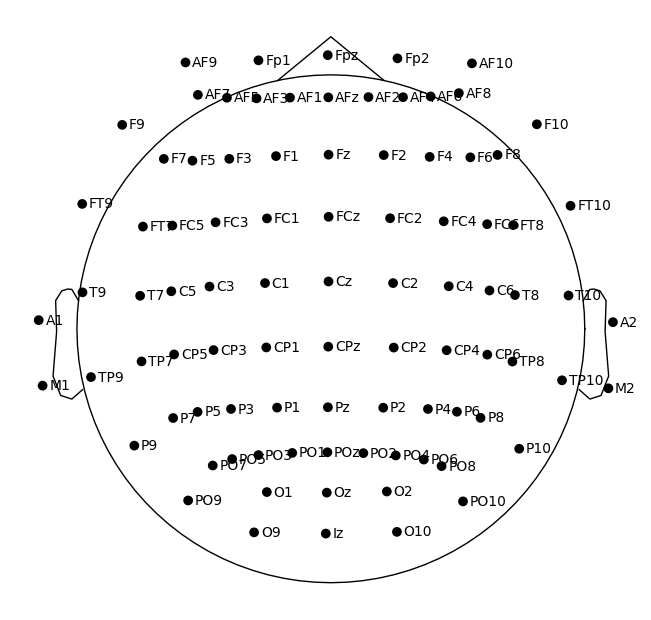

In [3]:
std_1020.plot()

In [4]:
import Journal_repo.data_util as data_util

data_path = "/home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/Data/BCICIV_2a_gdf" 
dataset = data_util.BCIGraphDataset(
    data_path=data_path,
    dataset_type='2a',
    subjects=['A01'],  # Use subset for quick test
    train=True,
    tmin=0.5,
    tmax=4.5,
    baseline=None,  # No baseline correction
    graph_type='fully_connected',  # or 'fully_connected
    k_neighbors=4,
    normalize=True
)

/home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Loading subject A01...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
  Original event IDs: [769, 770, 771, 772]
  Converted event IDs: [7, 8, 9, 10]
  Found 288 motor imagery trials
  Time window: tmin=0.5, tmax=4.5
  Baseline: None
  Class distribution: [72 72 72 72]
  Created 288 graphs

Loaded BCI Competition IV Dataset 2a (PyG Format)
Total trials: 288
Number of nodes (channels): 22
Number of edges: 462
Node feature dimension: 1001
Classes: 4 - ['left', 'right', 'foot', 'tongue']
Class distribution: [72 72 72 72]



In [5]:
print( dataset[0]['edge_attr'].squeeze(-1))

tensor([2.1822, 3.5355, 5.0000, 3.5355, 2.1822, 1.2403, 1.4003, 1.8569, 2.0000,
        1.8569, 1.4003, 1.2403, 1.1111, 1.2127, 1.2500, 1.2127, 1.1111, 0.9129,
        0.9759, 1.0000, 0.9759, 2.1822, 4.4721, 2.4254, 1.6440, 1.2500, 2.6726,
        3.1623, 2.6726, 1.9612, 1.4744, 1.0541, 0.9535, 1.6667, 1.5617, 1.3736,
        1.1704, 1.0000, 1.2403, 1.2127, 1.1111, 1.0000, 3.5355, 4.4721, 5.0000,
        2.5000, 1.6440, 1.8569, 2.2942, 3.3333, 2.7735, 2.0000, 1.3019, 1.1396,
        1.5617, 1.6667, 1.5811, 1.3867, 1.1704, 1.1785, 1.2403, 1.2127, 1.1111,
        5.0000, 2.4254, 5.0000, 5.0000, 2.4254, 1.4286, 1.6903, 2.7735, 3.3333,
        2.7735, 1.6903, 1.4286, 1.3736, 1.5811, 1.6667, 1.5811, 1.3736, 1.0911,
        1.2039, 1.2500, 1.2039, 3.5355, 1.6440, 2.5000, 5.0000, 4.4721, 1.1396,
        1.3019, 2.0000, 2.7735, 3.3333, 2.2942, 1.8569, 1.1704, 1.3867, 1.5811,
        1.6667, 1.5617, 0.9806, 1.1111, 1.2127, 1.2403, 2.1822, 1.2500, 1.6440,
        2.4254, 4.4721, 0.9535, 1.0541, 

In [6]:
from tsl.ops.connectivity import edge_index_to_adj
edge_index, edge_weights =dataset[0]['edge_index'], dataset[0]['edge_attr'].squeeze(-1)
adj = edge_index_to_adj(edge_index, edge_weights)

In [18]:
import tsl
from tsl.data import SpatioTemporalDataset

torch_dataset = SpatioTemporalDataset(target=dataset[0]['x'].T,
                                      connectivity=(dataset.edge_index, dataset.edge_attr.squeeze(-1))
                                      )

In [19]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler

# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)


In [20]:
dm.setup()
print(dm)


{Train dataloader: size=701}
{Validation dataloader: size=67}
{Test dataloader: size=197}
{Predict dataloader: None}


In [ ]:
import torch.nn as nn
import torch
from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation


class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_kernel: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.time_nn = RNN(input_size=hidden_size,
                           hidden_size=hidden_size,
                           n_layers=rnn_layers,
                           cell='gru',
                           return_only_last_state=True)
        
        self.space_nn = DiffConv(in_channels=hidden_size,
                                 out_channels=hidden_size,
                                 k=gnn_kernel)

        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

        self.classifier = torch.nn.Sequential(
        torch.nn.Linear(hidden_size, hidden_size // 2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(hidden_size // 2, 10),  # Assuming 10 classes for classification
    )

    def forward(self, x, edge_index, edge_weight):
        # x: [batch time nodes features]
        x_enc = self.encoder(x)  # linear encoder: x_enc = xΘ + b
        x_emb = x_enc + self.node_embeddings()  # add node-identifier embeddings
        h = self.time_nn(x_emb)  # temporal processing: x=[b t n f] -> h=[b n f]
        z = self.space_nn(h, edge_index, edge_weight)  # spatial processing
        x_out = self.decoder(z)  # linear decoder: z=[b n f] -> x_out=[b n t⋅f]
        x_horizon = self.rearrange(x_out)
        return x_horizon

In [22]:
hidden_size = 32   #@param
rnn_layers = 1     #@param
gnn_kernel = 2     #@param

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 207 nodes
horizon = torch_dataset.horizon         # 12 time steps

stgnn = TimeThenSpaceModel(input_size=input_size,
                           n_nodes=n_nodes,
                           horizon=horizon,
                           hidden_size=hidden_size,
                           rnn_layers=rnn_layers,
                           gnn_kernel=gnn_kernel)
print(stgnn)


TimeThenSpaceModel(
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (node_embeddings): NodeEmbedding(n_nodes=22, embedding_size=32)
  (time_nn): RNN(
    (rnn): GRU(32, 32)
  )
  (space_nn): DiffConv(32, 32)
  (decoder): Linear(in_features=32, out_features=1, bias=True)
  (rearrange): Rearrange('b n (t f) -> b t n f', t=1)
)


In [ ]:
import torch
from tsl.metrics.torch import MaskedMAE, MaskedMAPE
from tsl.engines import Predictor

loss_fn = MaskedMAE()

metrics = {'mae': MaskedMAE(),
           'mape': MaskedMAPE(),
           'mae_at_15': MaskedMAE(at=2),  # '2' indicates the third time step,
                                          # which correspond to 15 minutes ahead
           'mae_at_30': MaskedMAE(at=5),
           'mae_at_60': MaskedMAE(at=11),
           }


# setup predictor
predictor = Predictor(
    model=stgnn,                   # our initialized model
    optim_class=torch.optim.Adam,  # specify optimizer to be used...
    optim_kwargs={'lr': 0.001},    # ...and parameters for its initialization
    loss_fn=loss_fn,               # which loss function to be used
    metrics=metrics                # metrics to be logged during train/val/test
)

In [24]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir="logs", name="tsl_intro", version=0)

In [25]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 35167), started 0:05:13 ago. (Use '!kill 35167' to kill it.)

In [26]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)

trainer = pl.Trainer(max_epochs=100,
                     logger=logger,
                     limit_train_batches=100,  # end an epoch after 100 updates
                     callbacks=[checkpoint_callback])

trainer.fit(predictor, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | loss_fn       | MaskedMAE          | 0      | train | 0    
1 | train_metrics | MetricCollection   | 0      | train | 0    
2 | val_metrics   | MetricCollection   | 0      | train | 0    
3 | test_metrics  | MetricCollection   | 0      | train | 0    
4 | model         | TimeThenSpaceModel | 12.3 K | train | 0    
---------------------------------------------------------------------
12.3 K    Trainable params
0         Non-trainable params
12.3 K    Total params
0.049    

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
Only args ['x', 'edge_weight', 'edge_index'] are forwarded to the model (TimeThenSpaceModel).


/home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/theniche/Research/Hilbert-Bundle-Convolutional-Networks/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 55.73it/s, v_num=0, val_mae=0.0137, val_mae_at_15=0.000, val_mae_at_30=0.000, val_mae_at_60=0.000, val_mape=0.0655, train_mae=0.0151, train_mae_at_15=0.000, train_mae_at_30=0.000, train_mae_at_60=0.000, train_mape=0.113]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 54.12it/s, v_num=0, val_mae=0.0137, val_mae_at_15=0.000, val_mae_at_30=0.000, val_mae_at_60=0.000, val_mape=0.0655, train_mae=0.0151, train_mae_at_15=0.000, train_mae_at_30=0.000, train_mae_at_60=0.000, train_mape=0.113]
